**<center> <span style="color:#0F52BA;font-family:serif; font-size:34px;">Online Retail k_means Clustering</span> </center>**

<center><span style="font-family:Palatino; font-size:18px;"><i>Online retail is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

Business Goal:
We aim to segment the Customers based on RFM so that the company can target its customers efficiently.

The steps are broadly divided into:
* Step 1: Reading and Understanding the Data
* Step 2: Data Cleansing
* Step 3: Data Preparation
* Step 4: Model Building
* Step 5: Final Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# import required libraries for clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
import datetime as dt

# <span style="font-family:serif; font-size:28px;"> 1. Reading the data</span>

In [2]:
df = pd.read_csv("OnlineRetail.csv")

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# <span style="font-family:serif; font-size:28px;">2. Data cleaning</span>

In [7]:
# Calculating the Missing Values % contribution in DF

df_null = round((df.isnull().sum())/len(df)*100, 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [8]:
#Dropping null values

df = df.dropna()
print(df.shape)

(406829, 8)


In [9]:
# Changing the datatype of Customer Id as per Business understanding
df["CustomerID"] = df["CustomerID"].astype(str)

# <span style="font-family:serif; font-size:28px;">Step 3 : Data Preparation</span>

We are going to analysis the Customers based on below 3 factors:
* R (Recency): Number of days since last purchase
* F (Frequency): Number of tracsactions
* M (Monetary): Total amount of transactions (revenue contributed)

In [10]:
# New Attribute : Monetary

df['Amount'] = df['Quantity']*df['UnitPrice']
df_m = df.groupby('CustomerID')['Amount'].sum()
df_m = df_m.reset_index()
df_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [11]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [12]:
# New Attribute : Frequency

df_f = df.groupby('CustomerID')['InvoiceNo'].count()
df_f = df_f.reset_index()
df_f.columns = ['CustomerID', 'Frequency']
df_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [13]:
rfm = pd.merge(df_m, df_f, on = 'CustomerID', how = "inner")
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [14]:
# New Attribute : Recency

# Convert to datetime to proper datatype

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format='%d-%m-%Y %H:%M')
df['InvoiceDate'].head()

0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]

In [15]:
# Compute the maximum date to know the last transaction date

max_date = max(df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [16]:
# Compute the difference between max date and transaction date

df['Diff'] = max_date - df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [17]:
# Compute last transaction date to get the recency of customers

rfm_p = df.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [18]:
# Extract number of days only

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [19]:
# Merge tha dataframes to get the final RFM dataframe

rfm = pd.merge(rfm,rfm_p,on="CustomerID", how = "inner")
rfm.columns = ["CustomerID","Amount","Frequency","Recency"]
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


# <span style="font-family:serif; font-size:28px;">Outlier treatment</span>

Text(0.5, 0, 'Attributes')

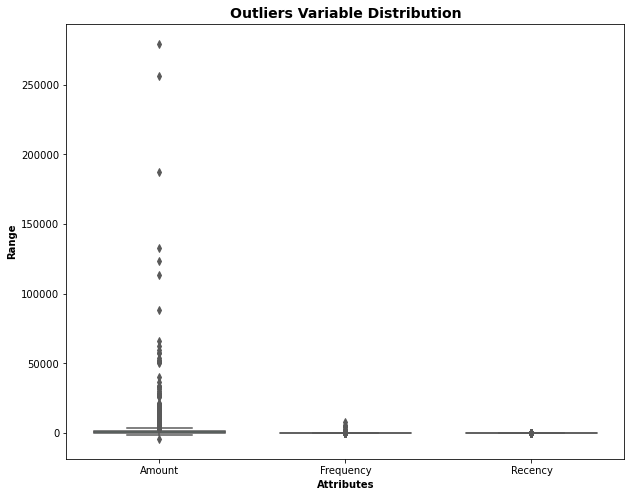

In [20]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [21]:
rfm.shape


(4372, 4)

In [22]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

In [23]:
rfm.shape

(4293, 4)

In [26]:
# mean = np.mean(rfm.Amount)
# std = np.std(rfm.Amount)
# print('mean of the TotalCharges is', mean)
# print('std. deviation is', std)

# threshold = 3
# outlier = []
# for i in rfm.Amount:
#     z = (i-mean)/std
#     if z > threshold:
#         outlier.append(i)
# print('outlier in dataset is', outlier)
# print(len(outlier))

mean of the TotalCharges is 1270.4114637782416
std. deviation is 1755.3466764433824
outlier in dataset is [11056.930000000004, 7877.200000000004, 13375.869999999992, 7829.889999999998, 8933.519999999999, 7116.47, 6546.580000000007, 13117.009999999993, 13309.039999999992, 11990.96, 9114.939999999993, 7187.339999999993, 9861.380000000003, 13612.069999999998, 13677.59, 12288.219999999998, 8221.09, 6814.240000000004, 9294.099999999993, 9120.39, 6989.629999999999, 6977.039999999999, 6748.4000000000015, 11581.8, 10930.259999999998, 7092.06, 6854.509999999997, 9797.920000000013, 7272.749999999996, 6912.0, 12432.279999999997, 8689.390000000003, 7741.47, 10510.000000000007, 9803.960000000003, 10664.33999999999, 7072.799999999994, 10736.47999999999, 9537.919999999998, 8910.609999999999, 6703.3, 7792.36, 8025.0199999999995, 8986.69, 7024.530000000005, 10464.85, 11216.74999999999, 12650.079999999996, 9167.820000000007, 11341.100000000002, 9231.200000000004, 9451.539999999997, 7904.279999999997, 11

### Rescaling the Attributes
#### It is extremely important to rescale the variables so that they have a comparable scale.| There are two common ways of rescaling:

* Min-Max scaling
* Standardisation (mean-0, sigma-1)
* Here, we will use Standardisation Scaling.

In [43]:
# Rescaling the attributes

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)

AttributeError: 'numpy.ndarray' object has no attribute 'head'

# <span style="font-family:serif; font-size:28px;">Step 4 : Buiding the model</span>

#### K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.

#### The algorithm works as follows:
 
* First we initialize k points, called means, randomly.
* We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
* We repeat the process for a given number of iterations and at the end, we have our clusters.

In [31]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)


KMeans(max_iter=50, n_clusters=4)

In [32]:
kmeans.labels_

array([1, 0, 3, ..., 1, 3, 3])

#### Elbow Curve to get the right number of Clusters
 A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

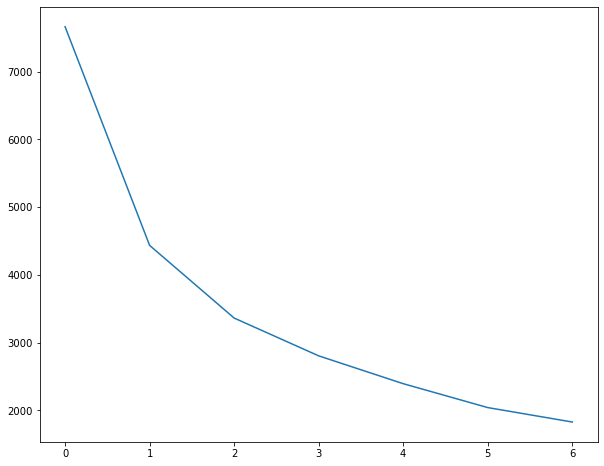

In [34]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

Silhouette Analysis
silhouette score=p−q/max(p,q)
 
p  is the mean distance to the points in the nearest cluster that the data point is not a part of

q  is the mean intra-cluster distance to all the points in its own cluster.

The value of the silhouette score range lies between -1 to 1.

A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [35]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5415858652525395
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.4781841150952288
For n_clusters=5, the silhouette score is 0.4662700564189704
For n_clusters=6, the silhouette score is 0.4173164913163161
For n_clusters=7, the silhouette score is 0.4154973843395972
For n_clusters=8, the silhouette score is 0.4089786560553438


In [36]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [37]:
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=1)

KMeans(max_iter=50, n_clusters=3, n_jobs=None, precompute_distances='auto',
       verbose=1)

In [38]:
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0])

In [39]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,2


<AxesSubplot:xlabel='Cluster_Id', ylabel='Amount'>

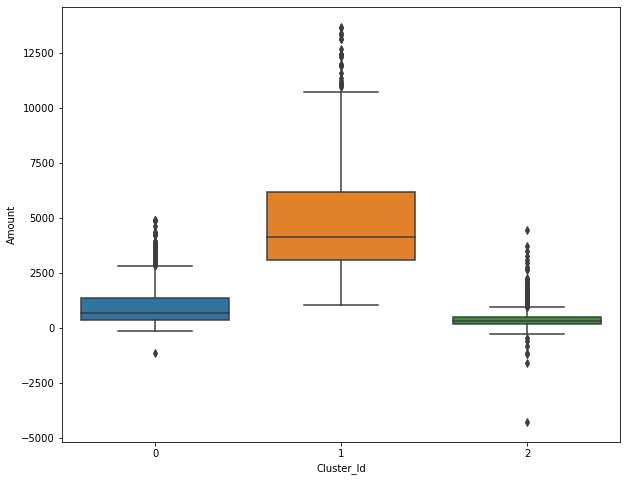

In [40]:
# Box plot to visualize Cluster Id vs Amount

sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

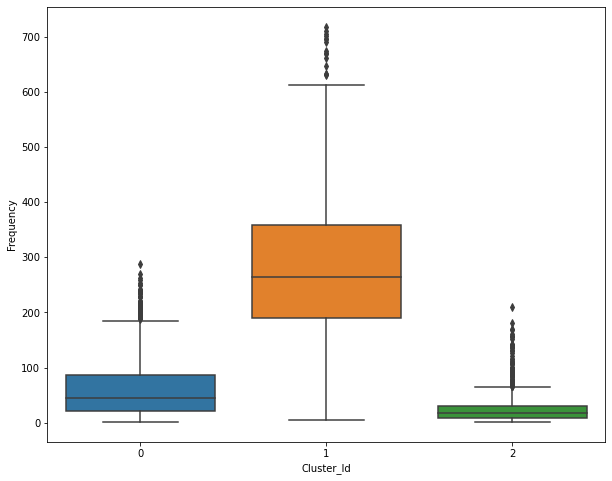

In [41]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

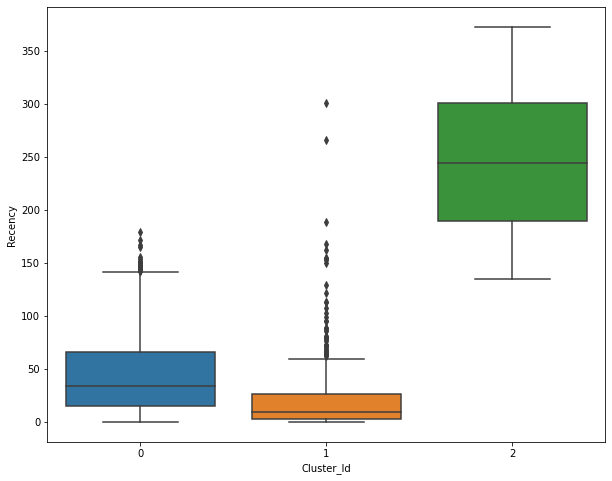

In [42]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

### Step 5 : Final Analysis
Inference:
K-Means Clustering with 3 Cluster Ids

* Customers with Cluster Id 1 are the customers with high amount of transactions as compared to other customers.
* Customers with Cluster Id 1 are frequent buyers.
* Customers with Cluster Id 2 are not recent buyers and hence least of importance from business point of view.